## preprocessing

In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

In [2]:
### 한글 및 부호 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic' #한글
mpl.rcParams['axes.unicode_minus'] = False #마이너스 부호

In [3]:
# csv 불러오기
train_data = pd.read_csv('trim_train_data.csv')
test_data = pd.read_csv('trim_test_data.csv')

In [4]:
# target 열을 임시로 분리
target_train = train_data['target']
target_test = test_data['target']

# 모든 값이 NaN인 열 제거
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')

# target 열을 다시 결합
train_data['target'] = target_train
test_data['target'] = target_test

### 기본적인 변수 정리

In [5]:
# Wip Line 열 제거
wip_line_columns = train_data.filter(like='Wip Line').columns

train_data.drop(columns=wip_line_columns, inplace=True)
test_data.drop(columns=wip_line_columns, inplace=True)

In [6]:
# Process Desc 열 제거
Process_Desc_col = train_data.filter(like='Process Desc').columns

train_data.drop(columns=Process_Desc_col, inplace=True)
test_data.drop(columns=Process_Desc_col, inplace=True)

In [7]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
Equipment_col2 = test_data.filter(like='Equipment').columns

new_train = train_data.filter(items=Equipment_col)
new_test = test_data.filter(items=Equipment_col2)

# Equipment_same_num 파생변수 생성
def determine_equipment_same_num(row):
    if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1') or \
       (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
        return 1
    else:
        return 0

train_data['Equipment_same_num'] = new_train.apply(determine_equipment_same_num, axis=1)
test_data['Equipment_same_num'] = new_test.apply(determine_equipment_same_num, axis=1)

train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
test_data = test_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])

In [8]:
# Model.Suffix_Dam의 이름을 Model.Suffix로 변경
train_data = train_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})
test_data = test_data.rename(columns={'Model.Suffix_Dam': 'Model.Suffix'})

# Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2 열 드롭
train_data = train_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_data = test_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])

In [9]:
# Workorder_Dam의 이름을 Workorder로 변경
train_data = train_data.rename(columns={'Workorder_Dam': 'Workorder'})
test_data = test_data.rename(columns={'Workorder_Dam': 'Workorder'})

# Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2 열 드롭
train_data = train_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_data = test_data.drop(columns=['Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])

In [10]:
# Insp. Seq No 열 제거
Insp_Seq_No_col = train_data.filter(like='Insp. Seq No').columns

train_data.drop(columns=Insp_Seq_No_col, inplace=True)
test_data.drop(columns=Insp_Seq_No_col, inplace=True)

In [11]:
# Insp Judge Code 열 제거
Insp_Judge_Code_col = train_data.filter(like='Insp Judge Code').columns

train_data.drop(columns=Insp_Judge_Code_col, inplace=True)
test_data.drop(columns=Insp_Judge_Code_col, inplace=True)

In [12]:
# 값의 종류가 1개이고 결측값이 없는 열을 제거하는 함수
def drop_single_value_columns(df):
    cols_to_drop = [col for col in df.columns if col != 'target' and df[col].nunique() == 1 and df[col].isnull().sum() == 0]
    df_dropped = df.drop(columns=cols_to_drop)
    return df_dropped, cols_to_drop

# train_data와 test_data에서 해당 열 제거 및 삭제된 열 이름과 개수 출력
train_data, train_cols_dropped = drop_single_value_columns(train_data)
test_data, test_cols_dropped = drop_single_value_columns(test_data)

# print("삭제된 train_data 열 이름:", train_cols_dropped)
print("삭제된 train_data 열 개수:", len(train_cols_dropped))

# print("삭제된 test_data 열 이름:", test_cols_dropped)
print("삭제된 test_data 열 개수:", len(test_cols_dropped))

삭제된 train_data 열 개수: 42
삭제된 test_data 열 개수: 42


### 제품 구분 관련 변수
model suffix와 workorder를 그대로 사용하는 것보다 receip no와 결합했을 때 타깃값 비율의 차이가 두드러졌다. 따라서 receip no를 하나라도 다른 것이 있으면 diff로 넣고, model suffix와 workorder와 결합된 파생변수를 만들어도 좋을 듯.
<br> -> workorder의 경우, 앞 4자리만 사용했을 때 타깃값 비율의 차이가 가장 잘 보여서 앞 4자리를 사용했고, receip no diff, 3.0, 9,0 3개와 결합한 경우와 모든 receip no와 결합한 경우 둘 다 타깃값 비율의 차이가 없었기 때문에 3개만 구분해주었다.

In [13]:
# 파생변수 생성: 3개의 컬럼 값이 모두 동일하면 해당 값을 저장, 아니면 diff
train_data['Receip_No'] = train_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)
test_data['Receip_No'] = test_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)

In [14]:
# 파생변수 생성: Receip No와 Model.Suffix의 조합
train_data['model_receip'] = train_data['Model.Suffix'] + '_' + train_data['Receip_No'].astype(str)
test_data['model_receip'] = test_data['Model.Suffix'] + '_' + test_data['Receip_No'].astype(str)

In [15]:
# 파생변수 생성: workorder 앞 4자리 -> workorder_prefix
train_data['workorder_prefix'] = train_data['Workorder'].str[:4]
test_data['workorder_prefix'] = test_data['Workorder'].str[:4]

In [16]:
# 파생변수 생성: Receip No와 workorder_prefix의 조합 -> diff, 3.0, 9.0의 경우에만
train_data['workorder_receip'] = train_data.apply(
    lambda row: f"{row['workorder_prefix']}_{row['Receip_No']}" 
    if row['Receip_No'] in ['diff', 3.0, 9.0] else row['workorder_prefix'],
    axis=1
)
test_data['workorder_receip'] = test_data.apply(
    lambda row: f"{row['workorder_prefix']}_{row['Receip_No']}" 
    if row['Receip_No'] in ['diff', 3.0, 9.0] else row['workorder_prefix'],
    axis=1
)

In [17]:
columns_to_drop = [
    'Model.Suffix',
    'Workorder',
    'workorder_prefix',
    'Receip_No',
    'Receip No Collect Result_Dam',
    'Receip No Collect Result_Fill1',
    'Receip No Collect Result_Fill2'
]

# 컬럼 드롭
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 좌표 관련 변수

##### 1. 합쳐서 범주형으로

In [18]:
'''
# 레진 도포 좌표 X, Y, Z 합치기
def create_coordinate_columns(data):
    # Dam
    # stage1
    data['head_normal_coordinate_stage1_Dam'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'].astype(str)
    )

    # stage2
    data['head_normal_coordinate_stage2_Dam'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'].astype(str)
    )

    # stage3
    data['head_normal_coordinate_stage3_Dam'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'].astype(str)
    )

    # Fill1
    # stage1
    data['head_normal_coordinate_stage1_Fill1'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'].astype(str)
    )

    # stage2
    data['head_normal_coordinate_stage2_Fill1'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'].astype(str)
    )

    # stage3
    data['head_normal_coordinate_stage3_Fill1'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'].astype(str)
    )

    # Fill2
    # stage1
    data['head_normal_coordinate_stage1_Fill2'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'].astype(str)
    )

    # stage2
    data['head_normal_coordinate_stage2_Fill2'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'].astype(str)
    )

    # stage3
    data['head_normal_coordinate_stage3_Fill2'] = (
        data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'].astype(str) + ',' +
        data['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'].astype(str)
    )

# train_data와 test_data에 대해 함수 호출
create_coordinate_columns(train_data)
create_coordinate_columns(test_data)
'''

"\n# 레진 도포 좌표 X, Y, Z 합치기\ndef create_coordinate_columns(data):\n    # Dam\n    # stage1\n    data['head_normal_coordinate_stage1_Dam'] = (\n        data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(str) + ',' +\n        data['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(str) + ',' +\n        data['HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'].astype(str)\n    )\n\n    # stage2\n    data['head_normal_coordinate_stage2_Dam'] = (\n        data['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'].astype(str) + ',' +\n        data['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(str) + ',' +\n        data['HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'].astype(str)\n    )\n\n    # stage3\n    data['head_normal_coordinate_stage3_Dam'] = (\n        data['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(str) + ',' +\n        data['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Da

In [20]:
'''
# 레진 도포 좌표 X, Y, Z 컬럼 드롭
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',

    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
]

# 컬럼 드롭
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)
'''

"\n# 레진 도포 좌표 X, Y, Z 컬럼 드롭\ncolumns_to_drop = [\n    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',\n    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',\n    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',\n\n    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',\n    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',\n    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',\n    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',\n    'HEAD NORMAL COORDINATE Y AXIS(S

In [21]:
'''
# UV 경화 좌표 합치기
def create_coordinate_columns(data):
    # Dam
    # cure end
    data['cure_end_position_XZΘ_Dam'] = (
        data['CURE END POSITION X Collect Result_Dam'].astype(str) + ',' +
        data['CURE END POSITION Z Collect Result_Dam'].astype(str) + ',' +
        data['CURE END POSITION Θ Collect Result_Dam'].astype(str)
    )

    # cure start
    data['cure_start_position_XΘ_Dam'] = (
        data['CURE START POSITION X Collect Result_Dam'].astype(str) + ',' +
        data['CURE START POSITION Θ Collect Result_Dam'].astype(str)
    )

    # Fill2
    # cure end
    data['cure_end_position_XZ_Fill2'] = (
        data['CURE END POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE END POSITION Z Collect Result_Fill2'].astype(str) 
    )

    # cure start
    data['cure_start_position_XZ_Fill2'] = (
        data['CURE START POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE START POSITION Z Collect Result_Fill2'].astype(str) 
    )

# train_data와 test_data에 대해 함수 호출
create_coordinate_columns(train_data)
create_coordinate_columns(test_data)
'''

"\n# \x08UV 경화 좌표 합치기\ndef create_coordinate_columns(data):\n    # Dam\n    # cure end\n    data['cure_end_position_XZΘ_Dam'] = (\n        data['CURE END POSITION X Collect Result_Dam'].astype(str) + ',' +\n        data['CURE END POSITION Z Collect Result_Dam'].astype(str) + ',' +\n        data['CURE END POSITION Θ Collect Result_Dam'].astype(str)\n    )\n\n    # cure start\n    data['cure_start_position_XΘ_Dam'] = (\n        data['CURE START POSITION X Collect Result_Dam'].astype(str) + ',' +\n        data['CURE START POSITION Θ Collect Result_Dam'].astype(str)\n    )\n\n    # Fill2\n    # cure end\n    data['cure_end_position_XZ_Fill2'] = (\n        data['CURE END POSITION X Collect Result_Fill2'].astype(str) + ',' +\n        data['CURE END POSITION Z Collect Result_Fill2'].astype(str) \n    )\n\n    # cure start\n    data['cure_start_position_XZ_Fill2'] = (\n        data['CURE START POSITION X Collect Result_Fill2'].astype(str) + ',' +\n        data['CURE START POSITION Z Collect Re

In [22]:
'''
# UV 경화 좌표 X, Y, Z 컬럼 드롭
columns_to_drop = [
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Θ Collect Result_Dam',

    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2'
]

# 컬럼 드롭
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)
'''

"\n# UV 경화 좌표 X, Y, Z 컬럼 드롭\ncolumns_to_drop = [\n    'CURE END POSITION X Collect Result_Dam',\n    'CURE END POSITION Z Collect Result_Dam',\n    'CURE END POSITION Θ Collect Result_Dam',\n    'CURE START POSITION X Collect Result_Dam',\n    'CURE START POSITION Θ Collect Result_Dam',\n\n    'CURE END POSITION X Collect Result_Fill2',\n    'CURE END POSITION Z Collect Result_Fill2',\n    'CURE START POSITION X Collect Result_Fill2',\n    'CURE START POSITION Z Collect Result_Fill2'\n]\n\n# 컬럼 드롭\ntrain_data.drop(columns=columns_to_drop, inplace=True)\ntest_data.drop(columns=columns_to_drop, inplace=True)\n"

In [23]:
"""
# Dam 노즐 zero 위치 Z좌표 드롭
train_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)
test_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)

'''
head_zero_position_YZ_Dam
300.0,265.0     20502
300.0,265.02    15247
303.5,265.0      4757
Name: count, dtype: int64
'''
"""

"\n# Dam 노즐 zero 위치 Z좌표 드롭\ntrain_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)\ntest_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)\n\n'''\nhead_zero_position_YZ_Dam\n300.0,265.0     20502\n300.0,265.02    15247\n303.5,265.0      4757\nName: count, dtype: int64\n'''\n"

##### 2. 파생변수 생성

In [24]:
'''
# 레진 도포 좌표 - 단위벡터 사용
def calculate_value(row):
    x, y, z = row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'], row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'], row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']
    # 거리 계산
    d = np.sqrt(x**2 + y**2 + z**2)
    # 단위 벡터 계산
    if d != 0:  # 0으로 나누는 것을 방지
        unit_vector = (x/d, y/d, z/d)
    else:
        unit_vector = (0, 0, 0)  # 거리 0일 때 단위 벡터는 정의되지 않음
    # 새로운 값 계산 (단위 벡터의 크기와 거리의 곱)
    value = d * 1  # 단위 벡터의 크기는 1이므로 단순히 거리 d
    return value

train_data['value_Dam'] = train_data.apply(calculate_value, axis=1)
'''

"\n# 레진 도포 좌표 - 단위벡터 사용\ndef calculate_value(row):\n    x, y, z = row['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'], row['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'], row['HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']\n    # 거리 계산\n    d = np.sqrt(x**2 + y**2 + z**2)\n    # 단위 벡터 계산\n    if d != 0:  # 0으로 나누는 것을 방지\n        unit_vector = (x/d, y/d, z/d)\n    else:\n        unit_vector = (0, 0, 0)  # 거리 0일 때 단위 벡터는 정의되지 않음\n    # 새로운 값 계산 (단위 벡터의 크기와 거리의 곱)\n    value = d * 1  # 단위 벡터의 크기는 1이므로 단순히 거리 d\n    return value\n\ntrain_data['value_Dam'] = train_data.apply(calculate_value, axis=1)\n"

### machine tact time

In [45]:
# tact time 차이를 저장한 두 개의 컬럼 생성
train_data['tact_time_Dam_Fill1'] = train_data['Machine Tact time Collect Result_Dam'] + train_data['Machine Tact time Collect Result_Fill1']
train_data['tact_time_Fill1_Fill2'] = train_data['Machine Tact time Collect Result_Fill1'] + train_data['Machine Tact time Collect Result_Fill2']

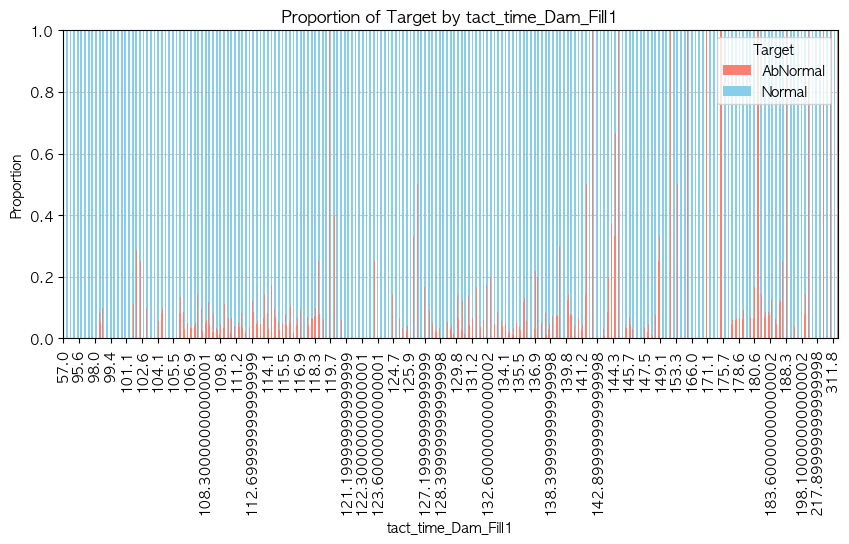

In [46]:
### tact_time_Dam_Fill1 따른 타깃값

# target 비율 계산
count_df = train_data.groupby(['tact_time_Dam_Fill1', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 4))

plt.xlabel('tact_time_Dam_Fill1')
plt.ylabel('Proportion')
plt.title('Proportion of Target by tact_time_Dam_Fill1')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(ticks=range(0, len(count_df), 20))

# 그래프 위에 비율 표시
#for i in range(count_df.shape[0]):
#    for j in range(count_df.shape[1]):
#        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

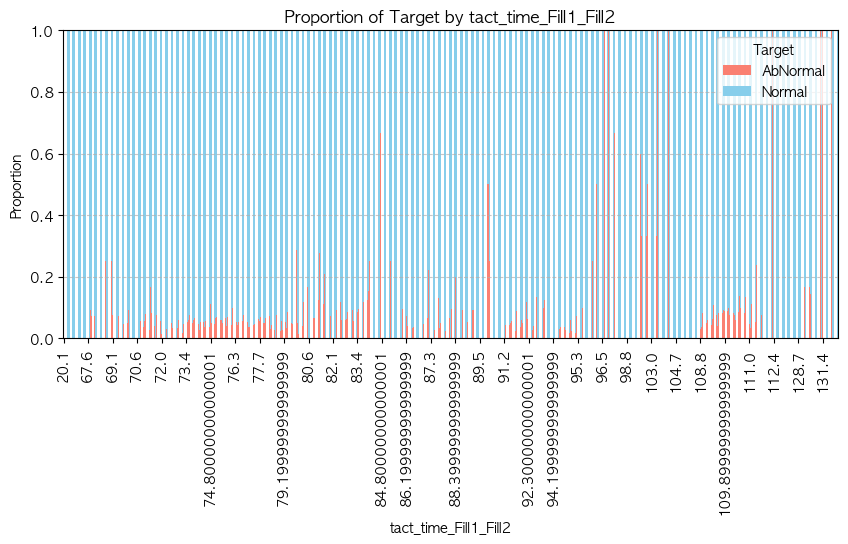

In [47]:
### tact_time_Fill1_Fill2 따른 타깃값

# target 비율 계산
count_df = train_data.groupby(['tact_time_Fill1_Fill2', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 4))

plt.xlabel('tact_time_Fill1_Fill2')
plt.ylabel('Proportion')
plt.title('Proportion of Target by tact_time_Fill1_Fill2')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(ticks=range(0, len(count_df), 20))

# 그래프 위에 비율 표시
#for i in range(count_df.shape[0]):
#    for j in range(count_df.shape[1]):
#        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

In [48]:
train_data['tact_time_full'] = train_data['tact_time_Dam_Fill1'] + train_data['tact_time_Fill1_Fill2']

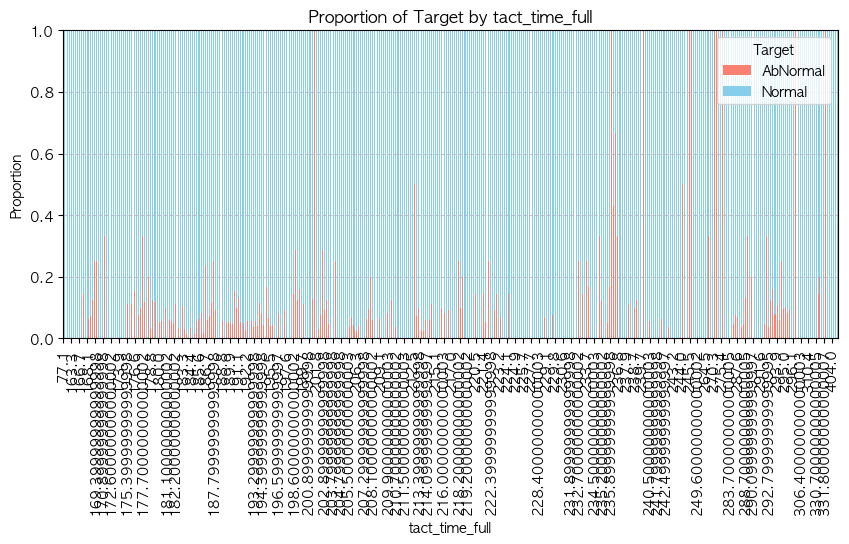

In [49]:
### tact_time_full 따른 타깃값

# target 비율 계산
count_df = train_data.groupby(['tact_time_full', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 4))

plt.xlabel('tact_time_full')
plt.ylabel('Proportion')
plt.title('Proportion of Target by tact_time_full')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(ticks=range(0, len(count_df), 20))

# 그래프 위에 비율 표시
#for i in range(count_df.shape[0]):
#    for j in range(count_df.shape[1]):
#        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

/var/folders/c6/kvlszyfj2q9_tv_8pb0y40qm0000gn/T/ipykernel_21306/4046204419.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = train_data.groupby(['tact_time_category', 'target']).size().unstack(fill_value=0)


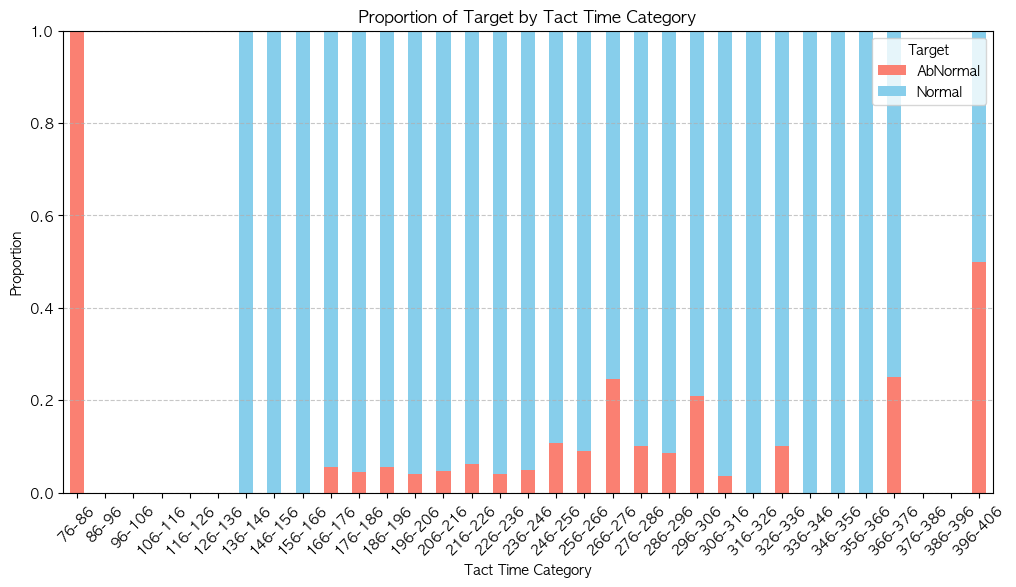

In [54]:
# tact_time_full 범주화
bins = list(range(76, 410, 10))  # 70에서 350까지 10 단위로 구간 생성
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(len(bins) - 1)]  # 범주 레이블 생성
train_data['tact_time_category'] = pd.cut(train_data['tact_time_full'], bins=bins, labels=labels, right=False)

# 타겟 비율 계산
count_df = train_data.groupby(['tact_time_category', 'target']).size().unstack(fill_value=0)
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(12, 6))

plt.xlabel('Tact Time Category')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Tact Time Category')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 위에 비율 표시
# for i in range(count_df.shape[0]):
#     for j in range(count_df.shape[1]):
#         plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

In [59]:
# 'tact_time_category'가 '76-86'인 경우
train_data[train_data['tact_time_category'] == '76-86']['model_receip'].value_counts()

model_receip
AJX75334501_diff    1
Name: count, dtype: int64

In [62]:
# 'tact_time_category'가 '256-266'인 경우
train_data[train_data['tact_time_category'] == '256-266']['model_receip'].value_counts()

model_receip
AJX75334501_1.0    10
AJX75334503_3.0     1
Name: count, dtype: int64

In [65]:
# 'tact_time_category'가 '396-406'인 경우
train_data[train_data['tact_time_category'] == '396-406']['model_receip'].value_counts()

model_receip
AJX75334501_1.0    1
AJX75334503_3.0    1
Name: count, dtype: int64

In [66]:
# 'tact_time_category'가 '286-296'인 경우
train_data[train_data['tact_time_category'] == '286-296']['model_receip'].value_counts()

model_receip
AJX75334501_1.0    8670
AJX75334502_1.0     155
AJX75334503_1.0       2
AJX75334507_1.0       1
Name: count, dtype: int64

-> abnormal 비율이 높은 경우 AJX75334501_1.0 비율이 높음 (불량률이 높은 모델)

In [25]:
# info 잘리지 않게 출력
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 116 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    CURE END POSITION X Collect Result_Dam                      float64
 1    CURE END POSITION Z Collect Result_Dam                      float64
 2    CURE END POSITION Θ Collect Result_Dam                      int64  
 3    CURE SPEED Collect Result_Dam                               int64  
 4    CURE START POSITION X Collect Result_Dam                    int64  
 5    CURE START POSITION Θ Collect Result_Dam                    int64  
 6    DISCHARGED SPEED OF RESIN Collect Result_Dam                int64  
 7    DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam         float64
 8    DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam         float64
 9    DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam         float64
 1